<a href="https://colab.research.google.com/github/tiasaxena/Pytorch/blob/main/06_pytorch_paper_replicating_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The task of this notebook is to turn a [ML research paper](https://arxiv.org/pdf/2010.11929) into useful code.

## 0. Setup

Import the code we have previously written + required libraries.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # Get the going_modular scripts
  print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 4393 (delta 1456), reused 1401 (delta 1401), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 26.29 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [3]:
# Set up device agnoistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get the data

The dataset we will be using is the same which we have used before, i.e., the pizza, sushi, steak images, which a subset of FoodVision Mini dataset.

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup the paths for train and test directory
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

The training resolution is 224(according to the ViT paper).

### 2.1 Prepare transforms for our images

In [6]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size according to the research paper
IMG_SIZE = 224

# Create transforms pipeline
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

data_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

### 2.2 Turn images into DataLoaders

The batch size is 4096 in the research paper. For the purpose of this notebook and limited compute, we will use `BATCH_SIZE=32`

In [7]:
import os

BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names =  data_setup.create_dataloaders(train_dir, test_dir, data_transform, BATCH_SIZE, os.cpu_count())

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a sample image

(-0.5, 223.5, 223.5, -0.5)

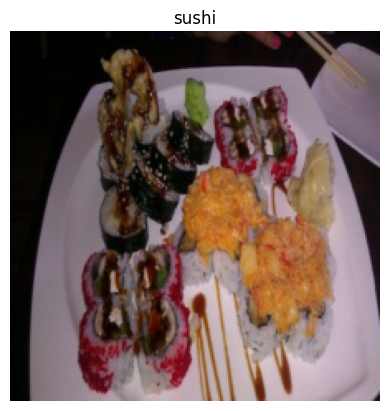

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
img, img_label = image_batch[0], label_batch[0]

plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[img_label.item()])
plt.axis(False)

## 3. Architechtural overview

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png)

Above, is the architecture which we are going to replicate.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

Above, are the equations or mathematical formulas which work together to form the Vision Transformer(ViT).

**Equation 1:**

The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2 D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

**Thus, pseudo code for equation 1:**
```python
# Equation 1:
x_input = [class_token + image_patch_1 + ... + image_patch_N] + [class_token_pos_embed + image_patch_1_pos_embed + ... + image_patch_N_pos_embed]
```

**Equation 2 & 3:**

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).
The MLP contains two layers with a GELU non-linearity.

**Pseudo code for Equation 2 & 3:**
```python
# Equation 2:
x_MSA_block_output = MultiHeadSelfAttention(LayerNorm(x_input)) + x_input

# Equation 3:
# MLP = a feed forward NN with x number of layers
x_MLP_block_output = MultiLayerPerceptron(LayerNorm(x_MSA_block_output)) + x_MSA_block_output
```


**Equation 4:**

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $y$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

**Pseudo code for Equation 4:**
```python
# Equation 4:
output = Linear_Layer(LayerNorm(x_MSA_block_output))
```

Configuration of the Bse ViT model that we are going to replicate:
1. Layers = 12 --> refers to the number of blocks of encoder
2. Hidden size D = 768 --> refers to the length of the vector in which our patches of the image will be represented
3. MLP Size = 3072 --> refers to the no. of hidden neurons
4. Heads = 12 --> refers to the no. of self-attention heads

## 4. Equation 1: Split data into patches and creating class, patch and position embedding

Layers = input -> function -> output

What's the input shape that goes into equation 1?
* 224 X 224 X 3 --> (height, width, color channels)

What's the output shape that comes out from equation 1?
* no. of patches X D (proof given below)

### 4.1 Finding the output shape of the eq 1 by hand

In [9]:
# Little proof that `P**2 X C == D`

# Given
D = 768
width, height, color_channels, patch_size = 224, 224, 3, 16

input_shape = (width, height, color_channels)
no_of_patches = int((width * height) / patch_size**2)

print(f"Input size of image to the embedding layer (equation 1): {input_shape}")
print(f"Number of patches: {no_of_patches}")

output_shape = (no_of_patches, patch_size**2 * color_channels)

print(f"Output shape from the equation 1: {output_shape}")
print(f"Thus, is D(768) == color_channels * patch_size**2? {D == output_shape[1]}")

Input size of image to the embedding layer (equation 1): (224, 224, 3)
Number of patches: 196
Output shape from the equation 1: (196, 768)
Thus, is D(768) == color_channels * patch_size**2? True


### 4.2 Turning a single image into patches

We have to split a single image into patches of dimension 16x16

In [10]:
img.shape

torch.Size([3, 224, 224])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


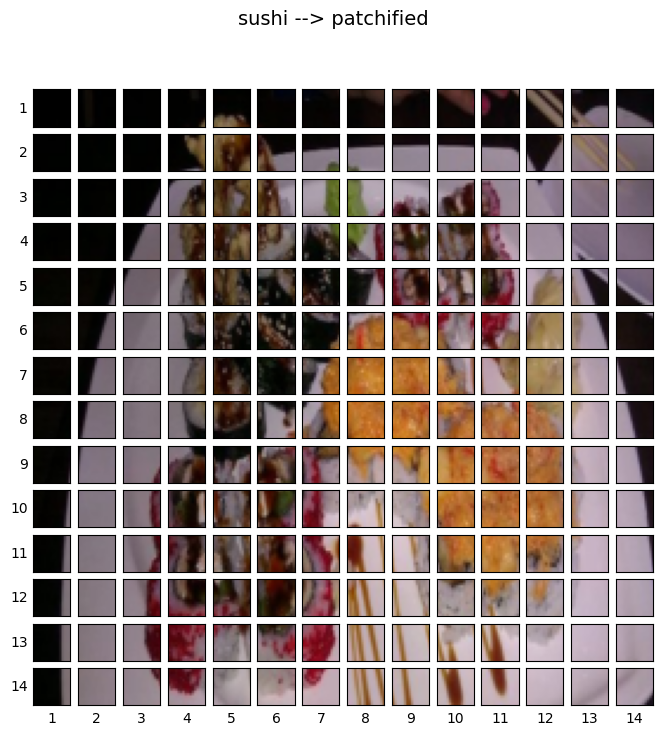

In [11]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_permute = img.permute(1, 2, 0)
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# img_size // patch_size --> perform the integer-division(floor)
fig, axes = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         figsize=(8, 8),
                         sharex=True,
                         sharey=True)

for row, patch_height in enumerate(range(0, img_size, patch_size)):
  for col, patch_width in enumerate(range(0, img_size, patch_size)):
    img_patch = img_permute[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :]
    axes[row, col].imshow(img_patch)
    axes[row, col].set_ylabel(row+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axes[row, col].set_xlabel(col+1)
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])
    axes[row, col].label_outer()

fig.suptitle(f"{class_names[img_label]} --> patchified", fontsize=14)
plt.show()

### 4.3 Creating image patches and turning image patches into patch embeddings

We can do both the steps using `torch.nn.Conv2D` of pytorch and setting kernel size and stride params equal to `patch_size`.

In [12]:
# Create conv2d layer to turn image into pcthes of learnable embeddings / feature maps
from torch import nn

# Set the patch size
patch_size = 16

# Create conv2d layer
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D of the model architechture
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [13]:
# Pass image through the conv2D layer
img_out_of_conv2d = conv2d(img.unsqueeze(0)) # add the batch dimension in the 0th index
img_out_of_conv2d.shape

torch.Size([1, 768, 14, 14])

Thus, we have batch size of 1, which is containing 1 image, divided into 14x14 boxes. Each of these box is represented by 768 values.

Showing random convolutional features maps of indexes: [535, 160, 658, 746, 336]


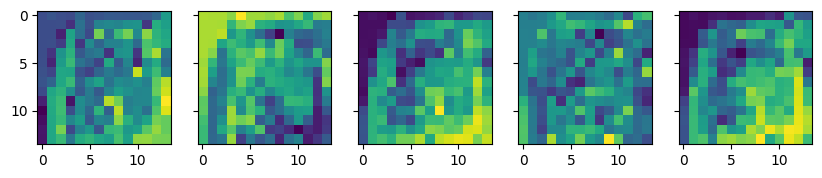

In [14]:
# visualize what we get out of the conv2d layer, i.e. the feature maps
import random

random_indexes = random.sample(range(0, 758), k = 5)

fig, axes = plt.subplots(nrows=1,
                         ncols=5,
                         figsize=(10, 6),
                         sharex=True,
                         sharey=True)
print(f"Showing random convolutional features maps of indexes: {random_indexes}")
for i, idx in enumerate(random_indexes):
  img_out_of_conv_layer = img_out_of_conv2d[:, idx, :, :]
  axes[i].imshow(img_out_of_conv_layer.squeeze().detach().numpy())

**Note**: These feature maps will be learned over time

### 4.4 Flattening the patch embeddings using `torch.nn.Flatten()`

In [15]:
flatten = nn.Flatten(start_dim=2, end_dim=3)
img_out_of_flatten = flatten(img_out_of_conv2d)
print(f"Shape of the image coming out of flatten layer:\n{img_out_of_flatten.permute(0, 2, 1).shape} --> (batch_size, num_of_patches, embedding_dimension)")

Shape of the image coming out of flatten layer:
torch.Size([1, 196, 768]) --> (batch_size, num_of_patches, embedding_dimension)


Text(0.5, 1.0, 'Flattened feature map shape: torch.Size([1, 196])')

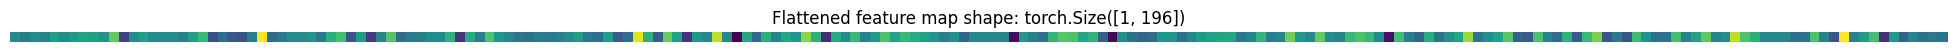

In [16]:
# Visualize a single feature map that came out from the flatten layer
img_out_of_flatten_permute = img_out_of_flatten.permute(0, 2, 1)

plt.figure(figsize=(25, 25))
plt.imshow(img_out_of_flatten_permute[:, :, 0].detach().numpy())
plt.axis(False)
plt.title(f"Flattened feature map shape: {img_out_of_flatten_permute[:, :, 0].shape}")

### 4.5 Turning the ViT patch embedding layer intoa PyTorch module

Steps:
1. Create a class `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize parameters.
3. Create a layer to convert image into patch embedding.
4. Create a layer to flatten feature maps.
5. Define `forward` method to do the forward computation.
6. Verify the output shape of the layers.  

In [17]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               embedding_dimension:int=768, # from ViT-16 base architecture config
               patch_size:int=16, # taken from the ViT-16 base architecture config
               ):
    super().__init__()

    self.patch_size = patch_size
    self.patcher = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dimension,
                            kernel_size=patch_size,
                            padding=0,
                            stride=patch_size)

    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self, input):
    # Create assertion to check that inputs are the correct shape
    image_resolution = input.shape[-1]
    assert image_resolution % patch_size == 0, f"Input  image size must be divisble by patch_size"

    patcher_output = self.patcher(input)

    flatten_output = self.flatten(patcher_output)

    # Adjust the dimension in the form of --> (batch_size, no_of_patches, embedding_resolution)
    return flatten_output.permute(0, 2, 1)

In [18]:
# Set seeds
set_seeds()

patchify = PatchEmbedding(in_channels=3,
               embedding_dimension=768,
               patch_size=16)

# Pass a single image from the patch embedding layer
print(f"Shape of the input image: {img.unsqueeze(0).shape}") # Add the batch_size dimension
patch_embed_image = patchify(img.unsqueeze(0))
print(f"Shape of the output image from the patch embedding layer: {patch_embed_image.shape}")

Shape of the input image: torch.Size([1, 3, 224, 224])
Shape of the output image from the patch embedding layer: torch.Size([1, 196, 768])


### 4.6 Creating the class embedding token

We want to prepend a learnable class token to the start of the patch embedding.

In [19]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension(D)
batch_size = patch_embed_image.shape[0]
embedding_dimension = patch_embed_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

**Note:** Since we are adding class token to the start of patch embeddings of each batch, the size will change from 196 to 197.

In [20]:
# Append the class token
img_with_class_embedding = torch.cat((class_token, patch_embed_image), dim=1)

img_with_class_embedding.shape

torch.Size([1, 197, 768])

### 4.7 Create the position embedding

We want to create a series of 1D learnable positional embeddings and add them to the sequence of patch embeddings.

In [21]:
# Calculate N(number of patches)
N = int((height * width) / patch_size**2)
embedding_dimension = img_with_class_embedding.shape[-1]

position_tokens = nn.Parameter(torch.ones(1, N+1, embedding_dimension), requires_grad=True)

img_with_positional_embedding = img_with_class_embedding + position_tokens
print(f"Shape of the image with positional embedding: {img_with_positional_embedding.shape}")

Shape of the image with positional embedding: torch.Size([1, 197, 768])


### 4.8 Putting all the above cells of section 4 together

Let's now put everything together in a single code cell and go from input image ($\mathbf{x}$) to output embedding ($\mathbf{z}_0$).

We can do so by:

1. Setting the patch size (we'll use 16 as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our PatchEmbedding layer.
4. Creating a PatchEmbedding layer (the one we made in section 4.5) with a patch_size=16 and embedding_dim=768 (from Table 1 for ViT-Base).
5. Passing the single image through the PatchEmbedding layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding like in section 4.6.
7. Prepending the class token embedding to the patch embeddings created in step 5.
8. Creating a position embedding like in section 4.7.
9. Adding the position embedding to the class token and patch embeddings created in step 7.

In [22]:
set_seeds()
image = img

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dimension=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: Multihead Self-Attention(MSA block)

In [23]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Values taken from the ViT paper architecture
               num_heads:int=12, # Values taken from the ViT paper architecture
               attn_dropout:int=0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(embedding_dim)
    self.multi_head_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                       num_heads=num_heads,
                                                       dropout=attn_dropout,
                                                      batch_first=True) # specifies that the batch_size should be placed first along the dimensions

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multi_head_attention(query=x,
                                               key=x,
                                               value=x,
                                               need_weights=False)
    return attn_output

In [24]:
# Create an instance of the MSA block
msa_block = MultiHeadSelfAttention(embedding_dim=768,
                                   num_heads=12,
                                   attn_dropout=0)
msa_block_output = msa_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {msa_block_output.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multi Layer Perceptron(MLP)

In [25]:
class MultiLayerPerceptron(nn.Module):
  def __init__(self,
               in_channel:int = 768,
               mlp_size:int = 3072, # From the ViT paper
               dropout:int = 0.1
               ):
    super().__init__()
    self.layer_norm = nn.LayerNorm(in_channel)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=in_channel,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=in_channel),
        nn.Dropout(p=dropout),
    )

  def forward(self, x):
    return self.mlp(self.layer_norm(x))

In [26]:
# Create an instance of MLPBlock
mlp_block = MultiLayerPerceptron(in_channel=768,
                                 mlp_size=3072,
                                 dropout=0.1)
mlp_block_output = mlp_block(msa_block_output)

print(f"Shape before MLP block: {msa_block_output.shape}")
print(f"Shape after MLP block: {mlp_block_output.shape}")

Shape before MLP block: torch.Size([1, 197, 768])
Shape after MLP block: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder
The Transformer Encoder is a combination of alternating blocks of MSA and MLP.

* Encoder = tun a sequence into learnable representations.
* Decoder = turns the learnable representations into some sort of sequence.
* Residual Connections = adds a layer(s) input to its subsequent output, this enables the creation of deeper networks by preventing weights form becoming too small.

In pseudo code:
```python
x_input --> MSA_block --> [MSA_block + x_input] --> MLP_block -> [MLP_block + MSA_block + x_input] --> ...
```

In [27]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               embedding_dimension:int = 768,
               num_heads:int = 12,
               mlp_size:int = 3072,
               mlp_dropout:int = 0.1,
               attn_dropout:int = 0):
    super().__init__()

    self.msa_block = MultiHeadSelfAttention(embedding_dim=embedding_dimension,
                                           num_heads=num_heads,
                                           attn_dropout=attn_dropout)

    self.mlp_block = MultiLayerPerceptron(in_channel=embedding_dimension,
                                         mlp_size=mlp_size,
                                         dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # `+ x` is done to add the skip/residual connection to the subsequent outputs
    x = self.mlp_block(x) + x # `+ x` is done to add the skip/residual connection to the subsequent outputs
    return x

In [28]:
# Create an instance TransformerEncoder block
transformer_encoder_block = TransformerEncoder(embedding_dimension=768,
                                  num_heads=12,
                                  mlp_size=3072,
                                  mlp_dropout=0.1,
                                  attn_dropout=0)

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape     Output Shape    Param #         Trainable
TransformerEncoder (TransformerEncoder)                 [1, 197, 768]   [1, 197, 768]   --              True
├─MultiHeadSelfAttention (msa_block)                    [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─MultiheadAttention (multi_head_attention)        --              [1, 197, 768]   2,362,368       True
├─MultiLayerPerceptron (mlp_block)                      [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─Sequential (mlp)                                 [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─Linear (0)                                  [1, 197, 768]   [1, 197, 3072]  2,362,368       True
│    │    └─GE

### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers¶
So far we've built the components of and the Transformer Encoder layer itself ourselves.

But because of their rise in popularity and effectiveness, PyTorch now has in-built [Transformer layers as part of torch.nn](https://pytorch.org/docs/stable/nn.html#transformer-layers)

For example, we can recreate the `TransformerEncoderBlock` we just created using [torch.nn.TransformerEncoderLayer()](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) and setting the same hyperparameters as above.

In [29]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [30]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

**Note**: The total numbers of params turns out to be same in both the cases.

There are benefits of using the PyTorch pre-built layers, such as:

* **Less prone to errors** - Generally, if a layer makes it into the PyTorch standard library, it's been tested and tried to work.
* **Potentially better performance** - As of July 2022 and PyTorch 1.12, the PyTorch implemented version of torch.nn.TransformerEncoderLayer() can see a [speedup of more than 2x on many common workloads](https://pytorch.org/blog/a-better-transformer-for-fast-transformer-encoder-inference/).

## 8. Putting it all together to create ViT

In [31]:
class ViT(nn.Module):
  # All the nomenclature for the params passed to the class are taken from the ViT research paper
  def __init__(self,
               img_size:int = 224, # Taken from the Vit-Base architecture
               in_channels:int=3, # Taken from the Vit-Base architecture
               patch_size:int  = 16, # Taken from the Vit-Base architecture
               hidden_size:int=768, # Taken from the Vit-Base architecture
               mlp_size:int = 3072, # Taken from the Vit-Base architecture
               layers:int = 12, # Taken from the Vit-Base architecture
               num_heads:int=12, # Taken from the Vit-Base architecture
               num_classes:int = 1000, # Taken from the Vit-Base architecture

               # Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.
               embedding_dropout:int = 0.1, # Dropout for the patch and position embeddings
               mlp_dropout:int = 0.1): # Taken from the Vit-Base architecture
    super().__init__()

    # 1. Make an assertion that the image size is divisble by patch_size
    assert img_size % patch_size == 0, f"Image size must be divisible by the patch size"

    # 2. Calculate the number of patches (height * width / pacth^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # 3. Create learnable class embeddings (needs to go at the front of the sequence of patch embeddings)
    self.class_embeddings = nn.Parameter(torch.randn(1, 1, hidden_size),
                                         requires_grad=True)

    # 4. Create learnable position embedding
    self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, hidden_size),
                                           requires_grad=True)

    # 5. Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # 6. Create the patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dimension=hidden_size)

    # 7. Create the transformer encoder block
    self.transformer_encoder =  nn.Sequential(*[TransformerEncoder(embedding_dimension=hidden_size,
                                                                   num_heads=num_heads,
                                                                   mlp_size=mlp_size,
                                                                   mlp_dropout=mlp_dropout) for _ in range(layers)])

    # 8. Create classifier head
    self.classifier = nn.Sequential(
      nn.LayerNorm(normalized_shape=hidden_size),
      nn.Linear(in_features=hidden_size, out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Createt class token embedding and expand it to match the batch size
    class_token = self.class_embeddings.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

    # Create the patch embedding (Equation 1)
    patch_embedding_output = self.patch_embedding(x)

    # Concatenate the class embedding (Equation 1)
    class_embedding_output = torch.cat((class_token, patch_embedding_output), dim=1)

    # Add the positional embeddings to the clas and patch embedding (Equation 1)
    position_embedding_output = self.position_embedding + class_embedding_output

    # Apply the dropout to patch embedding
    position_embedding_output_after_dropout = self.embedding_dropout(position_embedding_output)

    # Pass the position and class embedding to the transformer encoder (Equation 2 & 3)
    transformer_encoder_output = self.transformer_encoder(position_embedding_output_after_dropout)

    # Put the 0th index logit through the classifier (Equation 4)
    classifier_output = self.classifier(transformer_encoder_output[:, 0, :])

    return classifier_output


In [32]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [33]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoder (0)                                

## 9. Setting up training code for our ViT Model

We have replicated the ViT architecture. Let's now see its performance on our FoodVision Mini data.

### 9.1 Creating an optimizer

Searching the ViT paper for "optimizer", section 4.1 on Training & Fine-tuning states:

> Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with $\beta_{1}=0.9, \beta_{2}=0.999$, a batch size of 4096 and apply a high weight decay of $0.1$, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

So we can see they chose to use the "Adam" optimizer (torch.optim.Adam()) rather than SGD (stochastic gradient descent, torch.optim.SGD()).

The authors set Adam's $\beta$ (beta) values to $\beta_{1}=0.9, \beta_{2}=0.999$, these are the default values for the betas parameter in torch.optim.Adam(betas=(0.9, 0.999)).

They also state the use of weight decay (slowly reducing the values of the weights during optimization to prevent overfitting), we can set this with the weight_decay parameter in torch.optim.Adam(weight_decay=0.3) (according to the setting of ViT-* trained on ImageNet-1k).

We'll set the learning rate of the optimizer to 0.003 as per Table 3 (according to the setting of ViT-* trained on ImageNet-1k).



### 9.2 Create a Loss Function

Searching the ViT paper for "loss" or "loss function" or "criterion" returns no results.

However, since the target problem we're working with is multi-class classification (the same for the ViT paper), we'll use torch.nn.CrossEntropyLoss().

### 9.3 Training out ViT Model

In [34]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1949 | train_acc: 0.3633 | test_loss: 5.1213 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9517 | train_acc: 0.3320 | test_loss: 1.6205 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7585 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2245 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


### 9.4 What our training setup is missing

The main thing our model is misssing -
* Data - our setup has far less data
* Learning rate decay - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big

The original ViT architecture achieves good results on several image classification benchmarks (on par or better than many state-of-the-art results when it was released).

However, our results (so far) aren't as good.  
There's a few reasons this could be, but the main one is **scale**.  
The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule (see Table 3).

### Hyperparameter Comparison

| Hyperparameter | ViT Paper | Our Implementation |
|--------------|------------|--------------------|
| **Number of training images** | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225 |
| **Epochs** | 7 (for largest dataset), 90, 300 (for ImageNet) | 10 |
| **Batch size** | 4096 | 32 |
| [**Learning rate warmup**](https://paperswithcode.com/method/linear-warmup) | 10k steps (Table 3) | None |
| [**Learning rate decay**](https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b#:~:text=Learning%20rate%20decay%20is%20a,help%20both%20optimization%20and%20generalization.) | Linear/Cosine (Table 3) | None |
| [**Gradient clipping**](https://paperswithcode.com/method/gradient-clipping) | Global norm 1 (Table 3) | None |

Even though our ViT architecture is the same as in the paper, the results from the ViT paper were achieved using far more data and a more elaborate training scheme than ours.

Because of the size of the ViT architecture and its high number of parameters (increased learning capabilities), and the amount of data it uses (increased learning opportunities), many of the techniques used in the ViT paper training scheme—such as learning rate warmup, learning rate decay, and gradient clipping—are specifically designed to prevent overfitting (**regularization**).

> **Note:** For any technique you're unsure of, you can often quickly find an example by searching  
> `"pytorch TECHNIQUE NAME"`.  
> For example, if you wanted to learn about learning rate warmup and what it does, you could search  
> `"pytorch learning rate warmup"`.

### Pretrained ViT Models
Good news is, there are many **pretrained ViT models** (trained on vast amounts of data) available online.  
We'll see one in action in **section 10**.


### 9.5 Plotting loss curves or our model

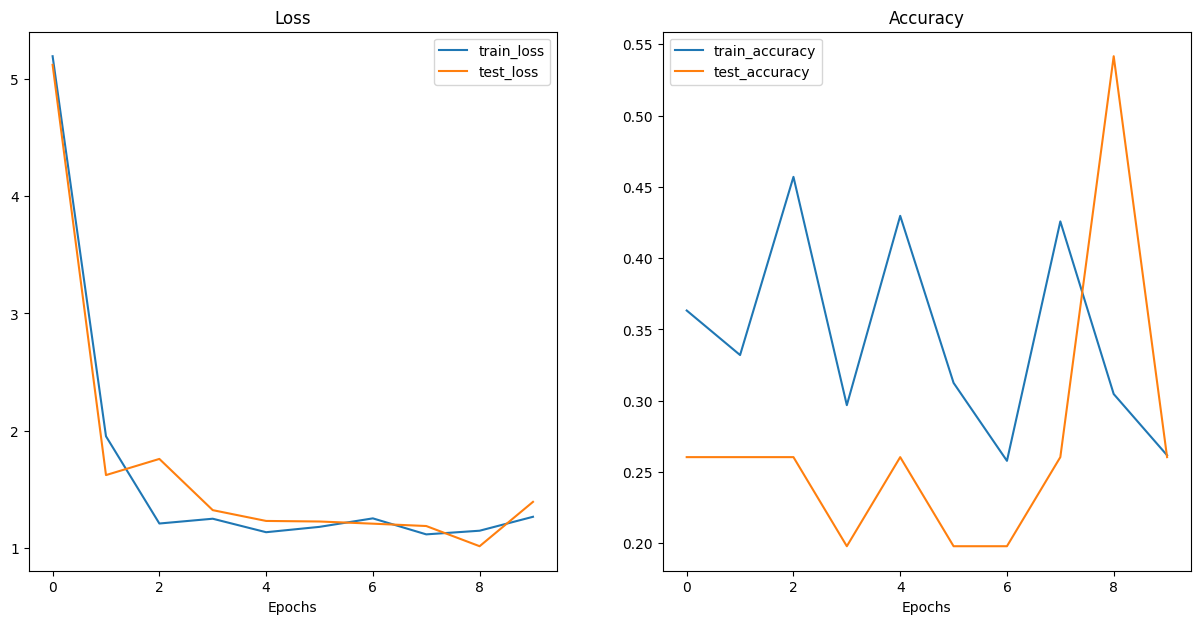

In [35]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

Our model is, thus, overfitting and underfitting at the same time.

## 10. Using a pretrained ViT drom `torchvision.models`

Generally, in Deep Learning, if you can use a pretrained model from a large dataset on your own problem, it is often a good place to start. If you can find a pretrained model and use transfer learning, give it a go, it often achieves great results with limited data.

### 10.1 **Why use a pretrained model?**
* Sometimes data is limited.
* Limited training resources.
* Get better results faster.

In [36]:
# The following requires torch v0.12+ and torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [38]:
# Get pre-trained wegjts for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Set up ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# Freez the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

  # Update the classifier head
  set_seeds()
  pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 145MB/s]


In [39]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 3]         768             Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [32, 197, 768]  [32, 197, 768]  151,296         False
│    └─Dropout (dropout)                                     [32, 197, 768]  [32, 197, 768]  --              --
│    └─Sequential (layers)                                   [32, 197, 768]  [32, 197, 768]  --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 

**Note:**
The number of params of out ViT and pre-trained ViT is, thus, the same.

### 10.3 Preparing data for the pretrained ViT model

When using a  pretrained model, you want to make sure your data is formated in the same way that the model was trained on.

In [40]:
# Fet automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [41]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [42]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

### 10.4 Train feature extractor ViT model

In [43]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

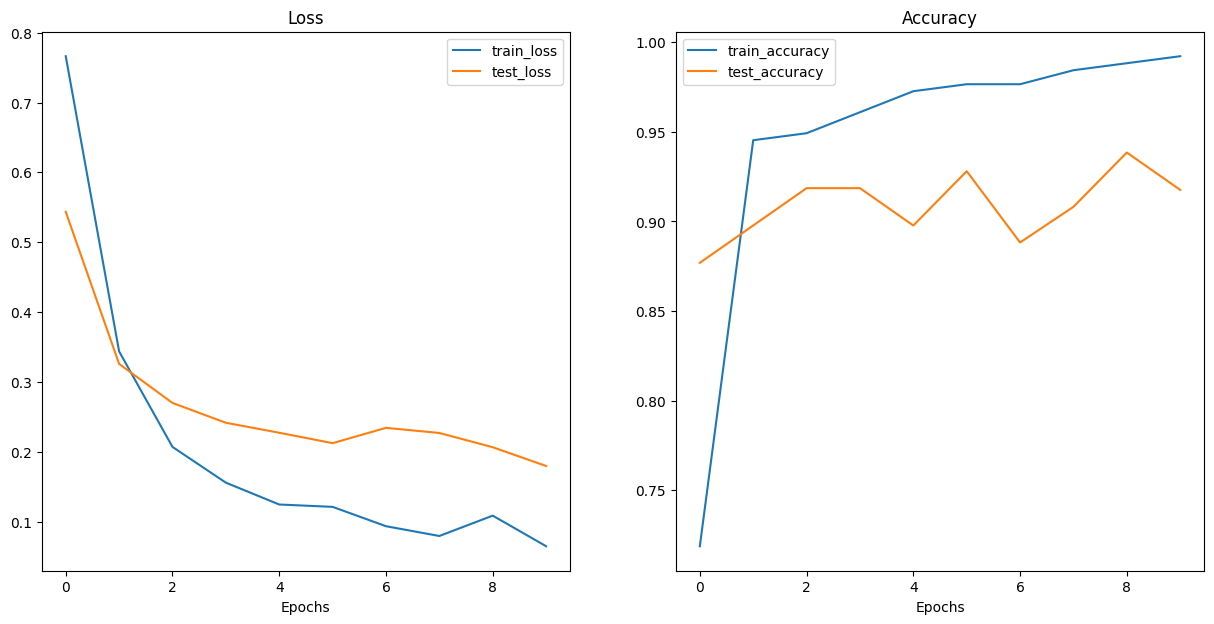

In [44]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT Model and check file size

However, we want to check the filesize because if we wanted to deploy a model to website/mobile application, we may have limitations on the size of the model we can deploy.

E.g., a smaller model may be required due to compute restrictions.

In [45]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [46]:
# Get the model size
from pathlib import Path

# Get the model size in Bytes
# Then, convert it into MegaBytes by finding the floor divison with 1024*1024
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)

print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB.")

Pretrained ViT feature extractor model size: 327 MB.


## 11. Make predictions on a custom image

images/images%20(1).jpeg already exists, skipping download.


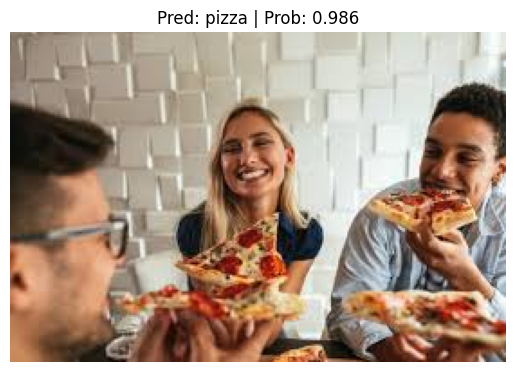

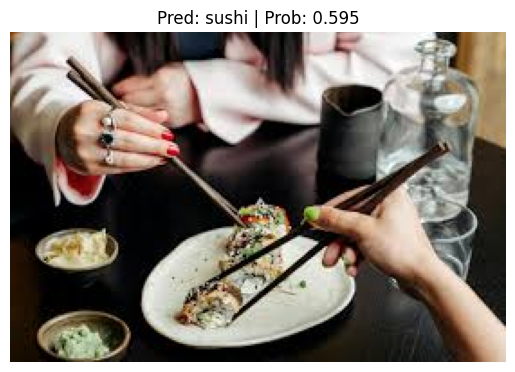

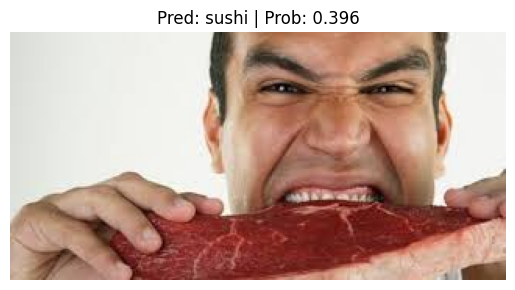

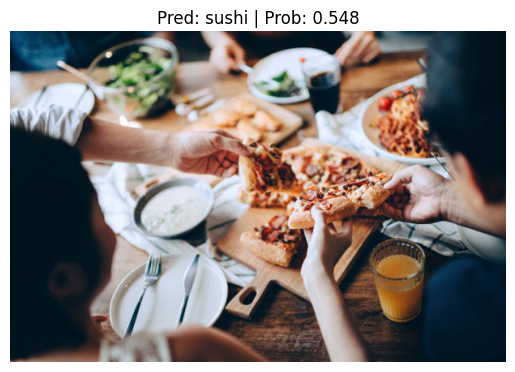

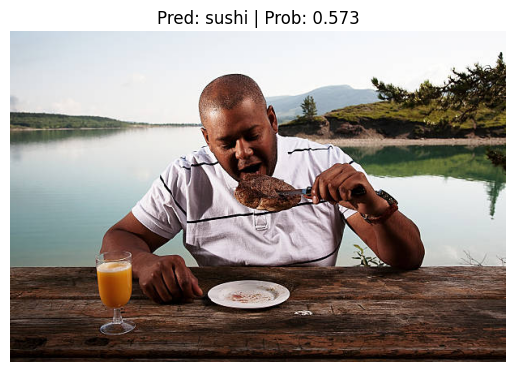

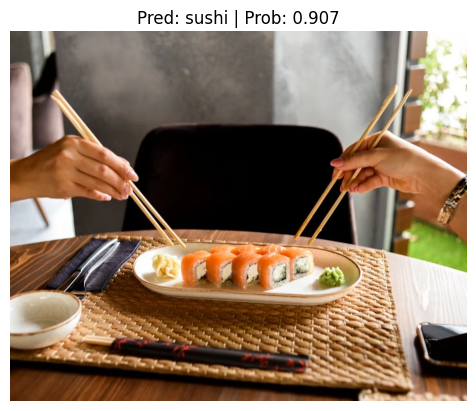

In [58]:
import requests
from pathlib import Path
from going_modular.going_modular.predictions import pred_and_plot_image

# List of image names to check and download
image_names = ["images%20(1).jpeg", "images%20(2).jpeg", "images.jpeg", "istockphoto-1343561122-612x612.jpg", "istockphoto-176074768-612x612.jpg", "pexels-photo-5616131.webp"]

# Define the base path for images
image_path = Path("./images")  # Ensure this directory exists
image_path.mkdir(parents=True, exist_ok=True)

# Base URL for downloading images
base_url = "https://raw.githubusercontent.com/tiasaxena/Pytorch/refs/heads/main/images/"

# Iterate through image names
for img_name in image_names:
    custom_image_path = image_path / img_name

    # Download the image if it doesn't already exist
    if not custom_image_path.is_file():
        with open(custom_image_path, "wb") as f:
            request = requests.get(base_url + img_name)
            print(f"Downloading {custom_image_path}...")
            f.write(request.content)
    else:
        print(f"{custom_image_path} already exists, skipping download.")
    # Predict on each image
    pred_and_plot_image(model=pretrained_vit,
                        image_path=custom_image_path,
                        class_names=class_names)
